In [1]:
import os
import sys

file_dir = os.getcwd()
sys.path.append(file_dir + "/../")
import torch
import numpy as np
from evaluation.calc_stats import calc_isi_stats, calculate_correlation
from vi_rnn.saving import load_model
from vi_rnn.utils import get_orth_proj_latents
from scipy.signal import coherence, welch, resample, butter, filtfilt
from scipy.stats import pearsonr, zscore
from scipy.ndimage import gaussian_filter1d
from neo.io.neuroscopeio import NeuroScopeIO

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

## we here use data from:
## https://crcns.org/data-sets/hc/hc-2/about-hc-2
## Mizuseki K, Sirota A, Pastalkova E, Buzsáki G., Neuron. 2009 Oct 29;64(2):267-80.
## (http://www.ncbi.nlm.nih.gov/pubmed/19874793).

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# model path
filename = "../models/hpc2/hc2rank3"

# spiking data path
# run the preprocessing notebooks in ../training_scripts/train_hippocampus to obtain these
test_spikes_path = "../data_untracked/test_hpc2.npy"
train_spikes_path = "../data_untracked/train_hpc2.npy"

# lfp path
# path = "/Users/akiferdemsagtekin/Documents/vi-rnns-hippo/data/ec013527" # change to where ever you put the files
lfp_path = "../data_untracked/ec013527.xml"

In [3]:
# load VAE
vae, params, task_params, training_params = load_model(str(filename))
rank = vae.dim_z
vae = vae.eval()

using clipped ReLU activation
using uniform init
weight scaler 1
cut_len: 0
key R_zq not found in rnn, deleted


In [4]:
# Load data
test_data = np.load(test_spikes_path)
train_data = np.load(train_spikes_path)

# cutting the last bits of spike data, because these are empty anyway
# + we want to match it with the size of the LFP data.
test_data = test_data[:, 0:-490]
dim_x, T = test_data.shape
_, T_train = train_data.shape
print("Data shape: ", test_data.shape)

Data shape:  (21, 20810)


In [5]:
# Run the trained network

# get data inferred initial state
z_hat, _, _, _ = vae.encoder(torch.from_numpy(test_data)[:, :1000].float().unsqueeze(0))
z0 = z_hat[0, :, 0]

# get latent trajectory (cut first 1000 time steps)
Z = vae.rnn.get_latent_time_series(time_steps=T, cut_off=1000, z0=z0, noise_scale=1)

# get spikes
lam = vae.rnn.get_observation(Z, noise_scale=0)[0, :, :, 0]
spikes_pred = torch.poisson(lam).T.detach().numpy()

# project latents on orthogonalised connnectivity and normalise
projection_matrix = get_orth_proj_latents(vae)
Z = projection_matrix @ Z[0, :, :, 0]
prior_Z = zscore(Z.detach().numpy(), axis=1)

# get posterior latents
k = 128  # number of particles
with torch.no_grad():
    Qzs_filt_avg, Qzs_sm_avg, Xs_filt_avg, Xs_sm_avg = vae.predict_NLB(
        torch.from_numpy(test_data).float().unsqueeze(0),
        u=None,
        k=k,
        t_held_in=T,
        t_forward=0,
        marginal_smoothing=False,
    )
Qzs_filt_avg = Qzs_filt_avg[0].mean(axis=-1)  # average over particles
Qzs_filt_avg = (
    projection_matrix @ Qzs_filt_avg
)  # project on orthogonalised connectivity
post_Z = zscore(Qzs_filt_avg.detach().numpy(), axis=1)  # normalise

In [6]:
# Load the LFP data
reader = NeuroScopeIO(filename=lfp_path)
seg = reader.read_segment(lazy=False)
t, c = np.shape(seg.analogsignals[0])
ds = []
fs = 100  # new sampling frequency in Hz
for i in range(c):
    lfp = np.array(seg.analogsignals[0][:, i])
    resample_rate = 1250 / fs
    n_samples = int(len(lfp) / resample_rate)
    lfp_ds = resample(lfp, n_samples)
    ds.append(lfp_ds)

lfp = np.array(ds)[:, :, 0]
test_lfp = lfp[:, T_train : T_train + T]

# z score lfp
test_lfp = zscore(test_lfp, axis=1)

# take the mean along the channels
test_lfp = np.mean(test_lfp, axis=0)

In [7]:
# estimate power spectral density
nperseg = 1024
f_test_lfp, psd_test_lfp = welch(
    test_lfp.reshape(-1), fs=fs, nperseg=nperseg
)  # Adjust nperseg as needed

In [8]:
# bandpass filter lfp and latents

# initialise a filter
t = np.arange(0, T) / fs  # Time vector
lowcut = 1
highcut = 40
low = lowcut / (fs / 2)
high = highcut / (fs / 2)
order = 4
b, a = butter(order, [low, high], btype="band")

# Apply the bandpass filter
lfp_filtered = filtfilt(b, a, test_lfp, axis=0)
prior_Z_filtered = filtfilt(b, a, prior_Z, axis=1)
post_Z_filtered = filtfilt(b, a, post_Z, axis=1)

In [9]:
# estimate power spectral density of the filtered signals
f_pZ1, psd_pZ1 = welch(prior_Z[0], fs=fs, nperseg=nperseg)
f_pZ2, psd_pZ2 = welch(prior_Z[1], fs=fs, nperseg=nperseg)
f_pZ3, psd_pZ3 = welch(prior_Z[2], fs=fs, nperseg=nperseg)
f_Z1, psd_Z1 = welch(post_Z[0], fs=fs, nperseg=nperseg)
f_Z2, psd_Z2 = welch(post_Z[1], fs=fs, nperseg=nperseg)
f_Z3, psd_Z3 = welch(post_Z[2], fs=fs, nperseg=nperseg)

In [10]:
# Calculate the correlations
corr1, _ = pearsonr(test_lfp, post_Z[0])
corr2, _ = pearsonr(test_lfp, post_Z[1])
corr3, _ = pearsonr(test_lfp, post_Z[2])
corr = [corr1, corr2, corr3]

p_corr1, _ = pearsonr(test_lfp, prior_Z[0])
p_corr2, _ = pearsonr(test_lfp, prior_Z[1])
p_corr3, _ = pearsonr(test_lfp, prior_Z[2])
p_corr = [p_corr1, p_corr2, p_corr3]

for i in range(rank):
    print("Correlation between LFP and post Z{}: {}".format(i + 1, corr[i]))
    print("Correlation between LFP and prior Z{}: {}".format(i + 1, p_corr[i]))

Correlation between LFP and post Z1: -0.15792049116397106
Correlation between LFP and prior Z1: 0.005657289461222929
Correlation between LFP and post Z2: 0.04216798886018001
Correlation between LFP and prior Z2: -0.0034579568217575156
Correlation between LFP and post Z3: -0.04473682361789714
Correlation between LFP and prior Z3: 0.0031153289891813884


In [11]:
# Compute coherence
f_coh_pZ1, Cxy_pZ1 = coherence(test_lfp, prior_Z[0], fs=fs, nperseg=1024)
f_coh_pZ2, Cxy_pZ2 = coherence(test_lfp, prior_Z[1], fs=fs, nperseg=1024)
f_coh_pZ3, Cxy_pZ3 = coherence(test_lfp, prior_Z[2], fs=fs, nperseg=1024)

f_coh_Z1, Cxy_Z1 = coherence(test_lfp, post_Z[0], fs=fs, nperseg=1024)
f_coh_Z2, Cxy_Z2 = coherence(test_lfp, post_Z[1], fs=fs, nperseg=1024)
f_coh_Z3, Cxy_Z3 = coherence(test_lfp, post_Z[2], fs=fs, nperseg=1024)

# convolve with gaussian kernel
sigma = 3
Cxy_pZ1 = gaussian_filter1d(Cxy_pZ1, sigma=sigma)
Cxy_Z1 = gaussian_filter1d(Cxy_Z1, sigma=sigma)

Cxy_pZ2 = gaussian_filter1d(Cxy_pZ2, sigma=sigma)
Cxy_Z2 = gaussian_filter1d(Cxy_Z2, sigma=sigma)

Cxy_pZ3 = gaussian_filter1d(Cxy_pZ3, sigma=sigma)
Cxy_Z3 = gaussian_filter1d(Cxy_Z3, sigma=sigma)

In [12]:
# Calculate correlation matrices
test_correlation = calculate_correlation(test_data.T)
gen_correlation = calculate_correlation(spikes_pred)
train_correlation = calculate_correlation(train_data.T)

# Extracting upper triangle values without the diagonal
i_upper = np.triu_indices(dim_x, k=1)
test_corr_values = test_correlation[i_upper]
gen_corr_values = gen_correlation[i_upper]
train_corr_values = train_correlation[i_upper]

In [13]:
# get ISI stats
CVs_isi_test, Means_isi_test, Std_isi_test = calc_isi_stats(test_data.T, dt=1 / fs)
CVs_isi_gen, Means_isi_gen, Std_isi_gen = calc_isi_stats(spikes_pred, dt=1 / fs)
CVs_isi_train, Means_isi_train, Std_isi_train = calc_isi_stats(train_data.T, dt=1 / fs)

In [14]:
# get firing rates
fr_test = np.mean(test_data, axis=1) * fs
fr_train = np.mean(train_data, axis=1) * fs
fr_gen = np.mean(spikes_pred, axis=0) * fs

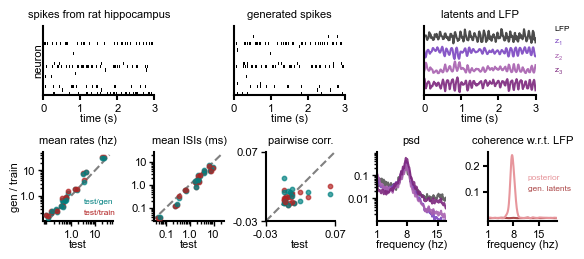

In [15]:
color1 = "#7B46C1"
color2 = "#A860AF"
color3 = "#7C277D"
color4 = "#8A44A4"
tg = "teal"
tr = "firebrick"
cmap = plt.get_cmap("tab20b")
cmap2 = plt.get_cmap("Dark2")

with mpl.rc_context(fname="matplotlibrc"):

    # Create a figure with specified size
    fig, axes = plt.subplots(2, 4, figsize=(6, 3))
    fig.subplots_adjust(hspace=0.2, wspace=0.6)

    ax1 = axes[0, 0]
    ax2 = axes[0, 2]
    ax3 = axes[0, 1]
    ax4 = axes[1, 0]
    ax5 = axes[1, 1]
    ax6 = axes[1, 2]
    ax7 = axes[0, 3]
    ax8 = axes[1, 3]

    # extract the width gap
    gap = ax5.get_position().x0 - ax4.get_position().x1

    # manually set the position for ax8
    pos = axes[1, 3].get_position()  # Get position of the third plot
    ax7.set_position([pos.x0 + pos.width + gap, pos.y0, pos.width, pos.height])

    # manually adjust the locations of wider plots
    width_scaling_factor = 1.6
    new_positions = []

    for i, ax in enumerate(axes[0, :3]):
        pos = ax.get_position()
        if i == 0:
            new_positions.append(
                [pos.x0, pos.y0, pos.width * width_scaling_factor, pos.height]
            )
        else:
            new_positions.append(
                [
                    new_positions[i - 1][0] + new_positions[i - 1][2] + gap * 4 / 2.1,
                    pos.y0,
                    pos.width * width_scaling_factor,
                    pos.height,
                ]
            )

    for i, ax in enumerate(axes[0, :3]):
        ax.set_position(new_positions[i])

    # data spikes
    sec = 3
    init = 3100
    duration = sec * fs
    ax1.imshow(
        test_data[:, init : init + duration],
        aspect="auto",
        cmap="Greys",
        interpolation="none",
        vmax=1,
    )
    ax1.set_xticks([0, 1 * 100, 2 * 100, 3 * 100])
    ax1.set_xticklabels([0, 1, 2, 3])
    ax1.set_yticks([])
    ax1.set_title("spikes from rat hippocampus")
    ax1.set_ylabel("neuron")
    ax1.set_xlabel("time (s)")

    # generated spikes
    ax3.imshow(
        spikes_pred[init : init + duration, :].T,
        aspect="auto",
        cmap="Greys",
        interpolation="none",
        vmax=1,
    )
    ax3.set_xticks([0, 1 * 100, 2 * 100, 300])
    ax3.set_xticklabels([0, 1, 2, 3])
    ax3.set_title("generated spikes")
    ax3.set_xlabel("time (s)")
    ax3.set_yticks([])

    # latents
    t = np.linspace(0, sec, duration)
    ax2.plot(
        t, prior_Z[0][init : init + duration] + 5, alpha=0.9, label="Z1", color=color1
    )
    ax2.plot(t, prior_Z[1][init : init + duration], alpha=0.9, label="Z2", color=color2)
    ax2.plot(
        t, prior_Z[2][init : init + duration] - 5, alpha=0.9, label="Z3", color=color3
    )
    cc = lfp_filtered[init : init + duration] + 10
    ax2.plot(t, cc, alpha=0.7, label="LFP", color="black")
    ax2.set_yticks([])
    ax2.set_xticks([0, 1, 2, 3])
    ax2.set_xlim(0, sec)
    ax2.set_yticks([])
    ax2.set_xlabel("time (s)")
    ax2.set_title("latents and LFP")

    # coefficient of variation
    # since model and test points overlap a lot, we want to make sure they are visible
    # apply random zorder values to each point

    n_dots = len(Means_isi_test)
    zorders = np.arange(n_dots * 2)
    np.random.shuffle(zorders)
    for i in range(n_dots):

        ax5.scatter(
            Means_isi_test[i],
            Means_isi_gen[i],
            s=10,
            alpha=0.7,
            color=tg,
            zorder=zorders[i],
        )
        ax5.scatter(
            Means_isi_test[i],
            Means_isi_train[i],
            s=10,
            alpha=0.7,
            color=tr,
            label="train",
            zorder=zorders[i + n_dots],
        )

    ax5.plot([0, 20], [0, 20], color="gray", linestyle="--", zorder=0)
    ax5.tick_params(axis="x", which="both", width=1)
    ax5.tick_params(axis="y", which="both", width=1)
    ax5.set_title("mean ISIs (ms)")
    ax5.set_xscale("log")
    ax5.set_yscale("log")
    ax5.set_xlabel("test")
    ax5.set_yticks([0.1, 1, 10])
    ax5.set_yticklabels(["0.1", "1.0", "10"])
    ax5.set_xticks([0.1, 1, 10])
    ax5.set_xticklabels(["0.1", "1.0", "10"])

    # mean rates
    ax4.plot(
        np.linspace(0, 40, 20),
        np.linspace(0, 40, 20),
        color="gray",
        linestyle="--",
        zorder=0,
    )
    n_dots = len(fr_test)
    zorders = np.arange(n_dots * 2)
    np.random.shuffle(zorders)
    for i in range(n_dots):
        ax4.scatter(fr_test[i], fr_gen[i], s=10, alpha=0.7, color=tg, zorder=zorders[i])
        ax4.scatter(
            fr_test[i],
            fr_train[i],
            s=10,
            alpha=0.7,
            color=tr,
            zorder=zorders[i + n_dots],
        )

    ax4.set_xscale("log")
    ax4.set_yscale("log")
    ax4.tick_params(axis="x", which="both", width=1)
    ax4.tick_params(axis="y", which="both", width=1)
    ax4.set_title("mean rates (hz)")
    ax4.set_yticks([1, 10])
    ax4.set_yticklabels(["1.0", "10"])
    ax4.set_xticks([1, 10])
    ax4.set_xticklabels(["1.0", "10"])
    ax4.set_xlabel("test")
    ax4.set_ylabel("gen / train")

    legend_labels = ["test/gen", "test/train"]
    legend_colors = [tg, tr]
    legend_elements = [
        plt.Line2D([0], [0], color=color, lw=0, label=label)
        for color, label in zip(legend_colors, legend_labels)
    ]
    legend = ax4.legend(
        handles=legend_elements,
        handletextpad=0,
        handlelength=0,
        fancybox=True,
        loc="upper right",
        bbox_to_anchor=(1.16, 0.45),
        fontsize=6,
    )

    for text, color in zip(legend.get_texts(), legend_colors):
        text.set_color(color)

    # pairwise correlation
    ax6.plot([-0.2, 0.4], [-0.2, 0.4], color="gray", linestyle="--", zorder=0)
    dots = len(test_corr_values)
    zorders = np.arange(n_dots * 2)
    np.random.shuffle(zorders)
    for i in range(n_dots):
        ax6.scatter(
            test_corr_values[i],
            gen_corr_values[i],
            s=10,
            alpha=0.7,
            color=tg,
            zorder=zorders[i],
        )
        ax6.scatter(
            test_corr_values[i],
            train_corr_values[i],
            s=10,
            alpha=0.7,
            color=tr,
            label="train",
            zorder=zorders[i + n_dots],
        )

    ax6.tick_params(axis="x", which="both", width=1)
    ax6.tick_params(axis="y", which="both", width=1)
    ax6.set_title("pairwise corr.")
    ax6.set_xlabel("test")
    ax6.set_yticks([-0.03, 0.07])
    ax6.set_yticklabels(["-0.03", "0.07"])
    ax6.set_xticks([-0.03, 0.07])
    ax6.set_xticklabels(["-0.03", "0.07"])
    ax6.set_xlim([-0.03, 0.07])
    ax6.set_ylim([-0.03, 0.07])

    # psd, shown are unfiltered signals, one could also show the filtered signals
    (line0,) = ax8.semilogy(
        f_test_lfp, psd_test_lfp, color="black", alpha=0.6, zorder=0, label="LFP"
    )
    (line1,) = ax8.semilogy(
        f_pZ1, psd_pZ1, color=color1, alpha=0.9, zorder=0, label="z 2"
    )
    (line2,) = ax8.semilogy(
        f_pZ2, psd_pZ2, color=color2, alpha=0.9, zorder=0, label="z 3"
    )
    (line3,) = ax8.semilogy(
        f_pZ3, psd_pZ3, color=color3, alpha=0.9, zorder=0, label="z 1"
    )

    # custom legend handles. note: legends were manually adjusted using illustrator afterwards to include the LFP signal
    legend_labels = ["$LFP$", "$z_1$", "$z_2$", "$z_3$"]
    legend_colors = ["black", color1, color2, color3]

    legend = ax8.legend(
        legend_labels,
        handletextpad=0,
        handlelength=0,
        fancybox=True,
        loc="upper right",
        bbox_to_anchor=(2.9, 2.95),
    )
    for text, color in zip(legend.get_texts(), legend_colors):
        text.set_color(color)

    ax8.set_xlim([1, 17])
    ax8.set_ylim([10**-3, 1])
    ax8.set_title("psd")
    ax8.set_xlabel("frequency (hz)")
    ax8.tick_params(axis="y", which="both", width=1)
    ax8.set_yticks([0.01, 0.1])
    ax8.set_yticklabels(["0.01", "0.1"])
    ax8.set_xticks([1, 8, 15])

    # LFP and zoomed latents
    init = int(18.3 * 40) + 1000
    duration = 1 * 40
    t = np.linspace(0, 1, duration)

    # note: we only showcase one prior latent and its corresponding posterior latent, because all latents are highly correlated
    ax7.plot(f_coh_pZ2, Cxy_pZ2**2, color=cmap(13), label="posterior", linewidth=1.5)
    ax7.plot(f_coh_Z2, Cxy_Z2**2, color=cmap(15), label="gen. latents", linewidth=1.5)
    legend_labels = ["posterior", "gen. latents"]
    legend_colors = [cmap(15), cmap(13)]
    # Add the custom legend to the plot
    legend = ax7.legend(
        legend_labels,
        handletextpad=0,
        handlelength=0,
        fancybox=True,
        loc="upper right",
        bbox_to_anchor=(1.3, 0.8),
        fontsize=6,
    )
    for text, color in zip(legend.get_texts(), legend_colors):
        text.set_color(color)

    ax7.set_xlabel("time (s)")
    ax7.set_xlim(1, 20)
    ax7.set_xticks([1, 8, 15])
    ax7.set_yticks([0.1, 0.2])
    ax7.set_title("coherence w.r.t. LFP")
    ax7.set_xlabel("frequency (hz)")

    plt.gcf().set_size_inches(5.2, 3)

    ax1.set_box_aspect(0.625)
    ax2.set_box_aspect(0.625)
    ax3.set_box_aspect(0.625)
    ax7.set_box_aspect(1)
    ax4.set_box_aspect(1)
    ax5.set_box_aspect(1)
    ax6.set_box_aspect(1)
    ax8.set_box_aspect(1)

    plt.savefig("../figures/hpc2_main.png", dpi=300)
    plt.savefig("../figures/hpc2_maincorfon.pdf", dpi=300)

    plt.show()